# POS tagging and NER.


In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
%%capture
import nltk
import os
from nltk import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

nltk.download("maxent_ne_chunker", quiet=True)
nltk.download("words", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)
nltk.download("tagsets", quiet=True)
nltk.download("conll2000", quiet=True)

In [3]:
sentence = word_tokenize("allow us to add lines in list of allow actions")
nltk.pos_tag(sentence)

[('allow', 'VB'),
 ('us', 'PRP'),
 ('to', 'TO'),
 ('add', 'VB'),
 ('lines', 'NNS'),
 ('in', 'IN'),
 ('list', 'NN'),
 ('of', 'IN'),
 ('allow', 'JJ'),
 ('actions', 'NNS')]

In [4]:
from nltk.corpus import conll2000

data = conll2000.chunked_sents()
print(data[1])

(S

  Chancellor/NNP

  (PP of/IN)

  (NP the/DT Exchequer/NNP)

  (NP Nigel/NNP Lawson/NNP)

  (NP 's/POS restated/VBN commitment/NN)

  (PP to/TO)

  (NP a/DT firm/NN monetary/JJ policy/NN)

  (VP has/VBZ helped/VBN to/TO prevent/VB)

  (NP a/DT freefall/NN)

  (PP in/IN)

  (NP sterling/NN)

  (PP over/IN)

  (NP the/DT past/JJ week/NN)

  ./.)


In [5]:
%%capture
!wget https://nlp.stanford.edu/software/stanford-parser-4.2.0.zip
!unzip stanford-parser-4.2.0.zip

In [6]:
from nltk.parse.stanford import StanfordParser

scp = StanfordParser(
    "stanford-parser-full-2020-11-17/stanford-parser.jar",
    "stanford-parser-full-2020-11-17/stanford-parser-4.2.0-models.jar",
)

sentence = "Innopolis University is a university located in the city of Innopolis."

result = list(scp.raw_parse(sentence))
print(result[0])

(ROOT

  (S

    (NP (NNP Innopolis) (NNP University))

    (VP

      (VBZ is)

      (NP

        (NP (DT a) (NN university))

        (VP

          (VBN located)

          (PP

            (IN in)

            (NP

              (NP (DT the) (NN city))

              (PP (IN of) (NP (NNP Innopolis))))))))

    (. .)))


In [7]:
!pip install svgling

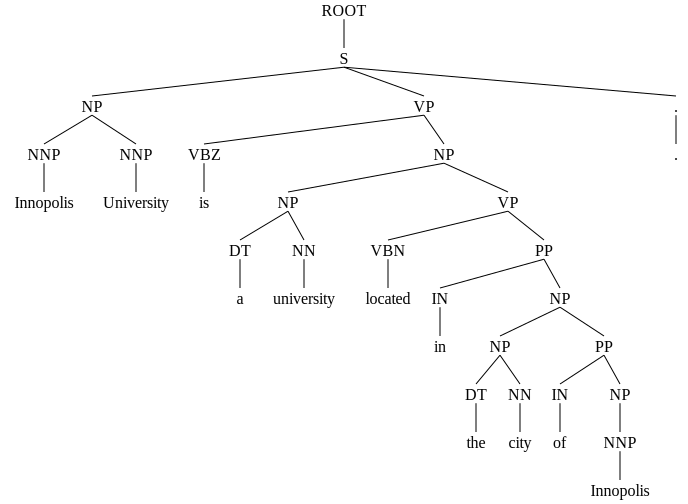

In [8]:
from IPython.display import display

display(result[0])

In [9]:
%%capture
!python -m spacy download en_core_web_sm

In [10]:
import spacy

text_processing_pipeline = spacy.load("en_core_web_sm")

processed_sentence = text_processing_pipeline(
    "Innopolis University is a university located in the city of Innopolis."
)

In [11]:
from spacy import displacy

displacy.render(
    processed_sentence,
    jupyter=True,
    options={"distance": 110, "arrow_stroke": 2, "arrow_width": 8},
)

## Named Entity Recognition


In [12]:
sentence = "European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices"

### Perfrom NER with spacy


In [13]:
from collections import Counter
import en_core_web_sm

In [14]:
text_processing_pipeline = en_core_web_sm.load()
doc = text_processing_pipeline(sentence)
print([(X.text, X.label_) for X in doc.ents])

[('European', 'NORP'), ('Google', 'ORG'), ('$5.1 billion', 'MONEY'), ('Wednesday', 'DATE')]


In [15]:
displacy.render(doc, style="ent", jupyter=True)

## Task

Perform NER on recipe ingridients


In [16]:
import spacy
from tqdm.notebook import tqdm
import pandas as pd

import random
from spacy.training import Example
from spacy.util import minibatch
from spacy.tokenizer import Tokenizer
import re

In [17]:
CLASS_MAPPING = {
    0: "DF",
    1: "NAME",
    2: "O",
    3: "QUANTITY",
    4: "SIZE",
    5: "STATE",
    6: "TEMP",
    7: "UNIT",
}
INVERSE_CLASS_MAPPING = {v: k for k, v in CLASS_MAPPING.items()}

In [18]:
df = pd.read_csv("train.csv")
df.head()

,tokens,labels
0,4 cloves garlic 2 cups cooked corned beef -LRB...,3 7 1 3 7 5 5 1 2 2 2 2
1,"2 tablespoons vegetable oil , divided 1 1/2 cu...",3 7 1 1 2 5 3 7 5 1
2,2 tablespoons dried marjoram 3 tablespoons pac...,3 7 0 1 3 7 5 1 1
3,"1 large red onion , 1/4-inch slices pulled int...",3 4 1 1 2 2 2 2 2 2 3 7 1 2 5
4,"2 jalapeno peppers , seeded and minced 1/2 - 3...",3 1 1 2 5 2 5 3 2 2 7 5 1 1


In [ ]:
train_data = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    tokens, labels = row["tokens"].split(" "), row["labels"].split(" ")
    entities = []
    position = 0
    for token, label in zip(tokens, labels):
        class_name = CLASS_MAPPING[int(label)]
        if class_name != "O":
            entities.append((position, position + len(token), class_name))
        position += len(token) + 1
    train_data.append((row["tokens"], {"entities": entities}))

In [20]:
train_data[0]

('4 cloves garlic 2 cups cooked corned beef -LRB- or canned -RRB-',
 {'entities': [(0, 1, 'QUANTITY'),
   (2, 8, 'UNIT'),
   (9, 15, 'NAME'),
   (16, 17, 'QUANTITY'),
   (18, 22, 'UNIT'),
   (23, 29, 'STATE'),
   (30, 36, 'STATE'),
   (37, 41, 'NAME')]})

In [21]:
text_processing_pipeline = spacy.blank("en")
text_processing_pipeline.add_pipe("ner", last=True)
ner = text_processing_pipeline.get_pipe("ner")

In [22]:
for _, annotations in train_data:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])
text_processing_pipeline.tokenizer = Tokenizer(
    text_processing_pipeline.vocab,
    token_match=re.compile(r"\S+").match,
)

In [ ]:
optimizer = text_processing_pipeline.begin_training()
epochs = 2
text_processing_pipeline.initialize()
for i in range(epochs):
    random.shuffle(train_data)
    losses = {}
    for batch in tqdm(minibatch(train_data, 8), total=len(train_data) // 8 + 1):
        examples = []
        for text, annotations in batch:
            examples.append(
                Example.from_dict(text_processing_pipeline.make_doc(text), annotations)
            )
        text_processing_pipeline.update(
            examples, drop=0.5, sgd=optimizer, losses=losses
        )
    print(losses)

In [24]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,token
0,0,1/2
1,1,large
2,2,sweet
3,3,red
4,4,onion


In [25]:
results = []
for i, row in test_df.iterrows():
    res = text_processing_pipeline(row["token"]).ents
    if res:
        results.append(INVERSE_CLASS_MAPPING[res[0].label_])
    else:
        results.append(INVERSE_CLASS_MAPPING["O"])

In [26]:
test_df["label"] = results
test_df = test_df.drop("token", axis=1)
test_df